# Data & Things

## Lecture : IoT and Data

<hr>
<h5> 7) IoT and sensor data </h5>
<ul>
    <li> There are two hand-in exercises for this topic:</li>
       <ul>
        <li>i. The first one is explained in bullet 2 of slide 16 of the slide deck “IoT & Sensor
        </li>Data.pptx”. You need to do the entire task described in bullet 2 of slide 16.
        <li>ii. The second one is related to PCA and it is explained in the notebook “pdm_task”.
            Note that the data simulation parts are already done for you, so you do not need
            to do those parts. You should start from the cell where tasks are listed and you
        </li> need to do all 5 tasks.
        </ul>
</ul>

<h5> bullet 2 of slide 16</h5>
<ul><li>Now, try youself:<br> Use the diabetes.csv dataset to do the following:</li>
 <ol>
    <li>Select the following 4 attributes(3 features+1 class label):</li>
        <ul><li>Glucose, BloodPreasure, Insulin, Outcome</li></ul>
    <li>Normalize Glucose, BloodPressure and Insulin to [0,1] using MinMax.</li>
    <li>Store the new data(3 normalized features + 1 class label) in another dataset S.</li>
    <li>Modify the MQTT example to do the following:</li>
        <ul>
            <li>The publisher publishes records in 5 continuously, When it reaches the end of S, it continues to send from the beginning again.</li>
            <li>The subscriber continuously receices the data. For each latest record r received, apply the 3NN classification to the last 5 records before r, and compare the classification result with the Outcome label in r.</li>
            <ul><li>Repeat this for 1000 times. and report the number of correct classifications.</li></ul>
        </ul>
 </ol>
</ul>

<hr>

<hr>
<h1>Exercise from slides</h1>

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [5]:
df = pd.read_csv("diabetes.csv")
display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<h3>Task 1 Select the following 4 attributes (3 features+1 class label): Glucose, BLoodPreasure, Insulin, Outcome</h3>

In [6]:
df_selected = df[['Glucose', 'BloodPressure', 'Insulin', 'Outcome']].copy()

<h3>Task 2 Normalize Glucose, BloodPressure and Insulin to [0,1] using MinMax <h3>

In [7]:
scaler = MinMaxScaler()
df_selected[['Glucose', 'BloodPressure', 'Insulin']] = scaler.fit_transform(df_selected[['Glucose', 'BloodPressure', 'Insulin']])

<h3>Task 3 Store the new data(3 normalized features + 1 class label) in another dataset S.</h3>

In [8]:
S = df_selected.reset_index(drop=True)

<h3>Task 4  </h3>
    <li>Modify the MQTT example to do the following:</li>
        <ul>
            <li>The publisher publishes records in 5 continuously, When it reaches the end of S, it continues to send from the beginning again.</li>
            <li>The subscriber continuously receices the data. For each latest record r received, apply the 3NN classification to the last 5 records before r, and compare the classification result with the Outcome label in r.</li>
            <ul><li>Repeat this for 10000 times. and report the number of correct classifications.</li></ul>
        </ul>

<p>Simulate MQTT publish/subscribe loop</p>

In [9]:
iterations = 1000 #Total times to simulate receiving new record
window_size = 5  #How many past records to keep as a training set
k_neighbors = 3 #Neighbor count in KNN / 3-NN for classification
correct_predictions = 0  
progress = []

records = S.values.tolist()
n_records = len(records)

#Each loop simulates a message received from the stream.
for i in range(iterations):
    index = i % n_records  # Simulate receiving records in a circular manner. Wraps around to row 1
    r = records[index] 


    if i >= window_size: # Only start predicting once we have window_size records before r

        start_index = (index - window_size) % n_records  # Around around


        if start_index + window_size <= n_records: #Get the last window_size records before r
            train_data = records[start_index:start_index + window_size]
        else:
            # If the window wraps around, split into two slices
            train_data = records[start_index:] + records[:(start_index + window_size) % n_records]
        #Spliting the features (X) and labels (y)
        train_X = [row[:3] for row in train_data] # First 3 columns = features
        train_y = [row[3] for row in train_data] # Last column = label / target

        # Train the KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k_neighbors)
        knn.fit(train_X, train_y)

        # Predict the label for the current record r
        pred = knn.predict([r[:3]])[0]

        if pred == r[3]: # If the prediction matches the actual value in label column
            correct_predictions += 1 # we coun the correct predictions

        # Calculate accuracy
        made_prediction = (i+1)-window_size
        # That means accuracy won’t steadily improve. It will bounce around depending on what the last 5 records look like.
        #It’s a simulation of real-time streaming classification, not a learning curve.
        acc_so_far = correct_predictions / made_prediction 
        progress.append(acc_so_far)

        #print every 50 itterations
        if (i+1) % 50 == 0:
            print(f"Iteration {i+1}/{iterations}, Correct Predictions: {correct_predictions}, Accuracy so far: {acc_so_far:.2f}")
        
#Final accuracy
print(f"Final Accuracy: {acc_so_far:.2f}")



Iteration 50/1000, Correct Predictions: 23, Accuracy so far: 0.51
Iteration 100/1000, Correct Predictions: 56, Accuracy so far: 0.59
Iteration 150/1000, Correct Predictions: 92, Accuracy so far: 0.63
Iteration 200/1000, Correct Predictions: 118, Accuracy so far: 0.61
Iteration 250/1000, Correct Predictions: 143, Accuracy so far: 0.58
Iteration 300/1000, Correct Predictions: 175, Accuracy so far: 0.59
Iteration 350/1000, Correct Predictions: 200, Accuracy so far: 0.58
Iteration 400/1000, Correct Predictions: 234, Accuracy so far: 0.59
Iteration 450/1000, Correct Predictions: 265, Accuracy so far: 0.60
Iteration 500/1000, Correct Predictions: 302, Accuracy so far: 0.61
Iteration 550/1000, Correct Predictions: 337, Accuracy so far: 0.62
Iteration 600/1000, Correct Predictions: 372, Accuracy so far: 0.63
Iteration 650/1000, Correct Predictions: 407, Accuracy so far: 0.63
Iteration 700/1000, Correct Predictions: 437, Accuracy so far: 0.63
Iteration 750/1000, Correct Predictions: 463, Accura

<h5>
My accuracy stabilizes around 0.62. This means the 3-NN classifer (with only the last 5 records as training data) correctly predicts the outcome 62% of the time. Given the tiny training set in a stream, it's reasonable. It's better than random guessing. The classifier does not learn over time. Each prediction is made fresh with only the last 5 rows so accuracy doesn't trend upwards permanently.

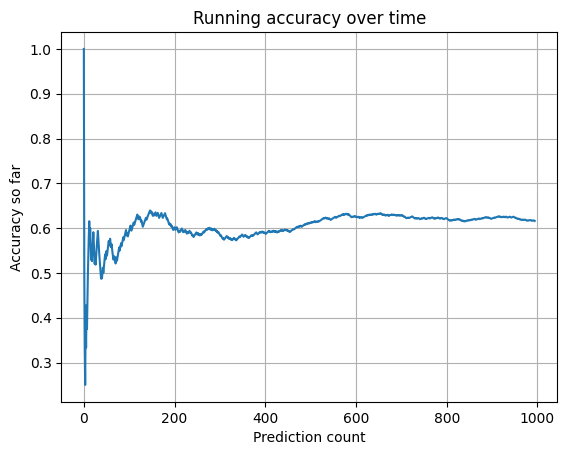

In [10]:
import matplotlib.pyplot as plt
plt.plot(progress)
plt.xlabel("Prediction count")
plt.ylabel("Accuracy so far")
plt.title("Running accuracy over time")
plt.grid(True)
plt.show()

<h5>
This plot swings at the start because a few predictions could be either 100% or 0% at the start. But it proves that accuracy is consistant. Maybe not the most interresting plot

<h1> Results: <br>613 correct out of 955 predictions (first 5 rows skipped as war-up)

<hr>
<h1> Exercise related to PCA

# Simulate sensor data & apply PCA

In this exercise, you will do the following:
1. Simulate sensor data
2. Apply PCA to simulated data
3. Simulate a new point
4. Find out which region the new point belongs to

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
# Step 1 Simulate synthetic predictive maintenance dataset
np.random.seed(42)
time_steps = 10000

sensors = {}
for i in range(1, 21):
    sensors[f'Sensor{i}'] = np.linspace(50, 100, time_steps) + np.random.normal(0, 20, time_steps)

# Combine into a DataFrame
data = pd.DataFrame(sensors)

print("Sample Data:")
print(data.head())

Sample Data:
     Sensor1    Sensor2    Sensor3    Sensor4    Sensor5    Sensor6  \
0  59.934283  36.430105  56.965725  10.388561  40.562849  51.964123   
1  47.239714  43.895011  55.671472  28.905288  70.259050  48.722836   
2  62.963772  38.062380  31.279604  38.269433  46.046264  69.045816   
3  80.475599  52.223362  61.606686  53.008380  51.826387  80.671624   
4  45.336935  73.963573  20.218348  70.503249  64.367814  63.756941   

     Sensor7    Sensor8    Sensor9   Sensor10   Sensor11   Sensor12  \
0  51.576755  56.403048  63.280022  69.217891  70.611892  66.017477   
1  61.262950  72.314233  44.082680  42.605706  26.897905  49.021813   
2  56.832040  19.905237  48.678273  38.418383  61.518745  41.079748   
3  24.456718  84.807115  46.507354  68.681245  37.630232  53.375301   
4  46.295596  56.621738  60.301076  -4.610793  43.471946   7.484493   

    Sensor13   Sensor14   Sensor15   Sensor16   Sensor17   Sensor18  \
0  45.626995  72.350652  44.689254  77.397560  78.652455  13.5

<hr>
<h3><code>.fit_transform</code> is important here, because it's where the historical data is used to fit the transformation space. Basiclly I only want to fit once here, so it can be used in later observations to standarized after the same.</h3>

In [13]:
# Step 2: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Display scaled data
print("Scaled Data Sample:")
print(pd.DataFrame(scaled_data, columns=data.columns).head())

Scaled Data Sample:
    Sensor1   Sensor2   Sensor3   Sensor4   Sensor5   Sensor6   Sensor7  \
0 -0.610580 -1.566006 -0.725010 -2.596654 -1.407431 -0.927666 -0.969437   
1 -1.126525 -1.265030 -0.777771 -1.850742 -0.198347 -1.057996 -0.572396   
2 -0.487452 -1.500195 -1.772111 -1.473524 -1.184173 -0.240819 -0.754021   
3  0.224281 -0.929241 -0.535820 -0.879792 -0.948835  0.226649 -2.081098   
4 -1.203859 -0.052701 -2.223025 -0.175043 -0.438209 -0.453482 -1.185914   

    Sensor8   Sensor9  Sensor10  Sensor11  Sensor12  Sensor13  Sensor14  \
0 -0.746813 -0.479506 -0.232249 -0.186682 -0.367113 -1.184181 -0.110562   
1 -0.106939 -1.258090 -1.320570 -1.955170 -1.054209 -0.697301 -0.772550   
2 -2.214587 -1.071707 -1.491814 -0.554553 -1.375289 -0.412171 -0.701019   
3  0.395468 -1.159753 -0.254195 -1.520984 -0.878208 -1.964016 -1.982653   
4 -0.738018 -0.600323 -3.251518 -1.284652 -2.733470 -0.924990 -0.686938   

   Sensor15  Sensor16  Sensor17  Sensor18  Sensor19  Sensor20  
0 -1.220616  0

Do the following tasks:
1. Apply PCA with upto 5 components
2. Visualize how much variance of the dataset is defined by each component
3. Visualize the first 2 principal components and color them by timestep
4. Simulate a new position using code below
5. Plot the new point in the original 2D PCA graph

<hr>
<h3>Task 1 Apply PCA with upto 5 components</h3>

In [14]:
# Step 3: Apply PCA to the scaled data
pca = PCA(n_components=5) # Task apply PCA with up to 5 components
X_pca = pca.fit_transform(scaled_data) # scaled_data already standardized in step 2

# Step 4: Simulate a new observation and predict its position
new_observation = np.array([[75] * 20])
scaled_new_observation = scaler.transform(new_observation)
new_pca = pca.transform(scaled_new_observation)

print("New observation PCA position:", new_pca)

New observation PCA position: [[-0.00353968  0.01164137 -0.00388459  0.0007376   0.00233923]]


c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [20]:
scaled_array = np.asarray(scaled_data, dtype=float)


X_pca = pca.transform(scaled_array)  

timestep = np.arange(X_pca.shape[0])

print("scaled_data shape:", scaled_array.shape)
print("X_pca shape:", X_pca.shape)
print("per component:", np.round(pca.explained_variance_ratio_, 4))
print("Cumulative:", np.round(np.cumsum(pca.explained_variance_ratio_), 4))


scaled_data shape: (10000, 20)
X_pca shape: (10000, 5)
per component: [0.3769 0.0359 0.0351 0.0349 0.0343]
Cumulative: [0.3769 0.4128 0.4479 0.4828 0.517 ]


<hr>
<h3>Task 2 Visualize how much variance of the dataset is defined by each component</h3>

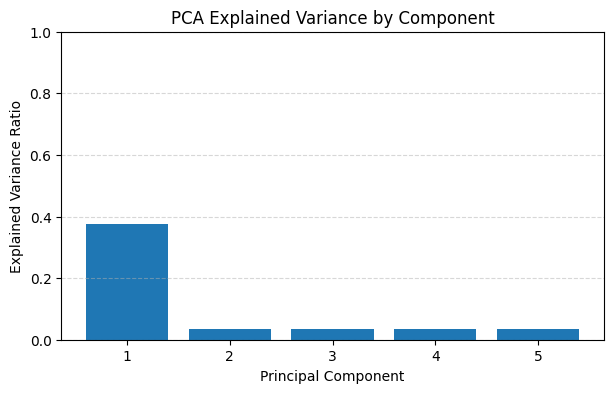

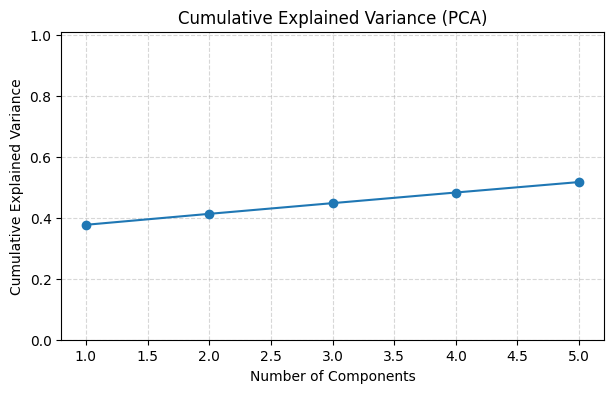

In [19]:
import matplotlib.pyplot as plt
import numpy as np

evr = pca.explained_variance_ratio_
cev = np.cumsum(evr)

# Each component bar
plt.figure(figsize=(7,4))
plt.bar(range(1, len(evr)+1), evr)
plt.title("PCA Explained Variance by Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Cumulative line
plt.figure(figsize=(7,4))
plt.plot(range(1, len(cev)+1), cev, marker='o')
plt.title("Cumulative Explained Variance (PCA)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.ylim(0, 1.01)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


<h3>The results show that around 38% of variance can be explained by pc1, while all the other components only explain under 5%</h3>
<hr>
<h3>Task 3 Visualize the first 2 principal components and color them by timestep</h3>

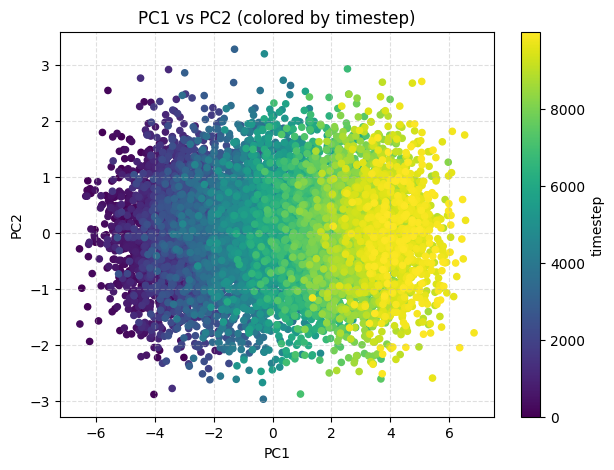

In [17]:
import matplotlib.pyplot as plt

pc1, pc2 = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(7,5))
sc = plt.scatter(pc1, pc2, c=timestep, s=20)  # color by time index
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 (colored by timestep)")
cbar = plt.colorbar(sc)
cbar.set_label("timestep")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


<h3>It's important to remmber PC1 explains 38% of the variance, while PC2 is only around 2%. So X-axis is more have much higher weight</h3>
<hr>
<h3>Task 4 + 5 Simulate a new position /Plot the new point in the original 2D PCA graph</h3>

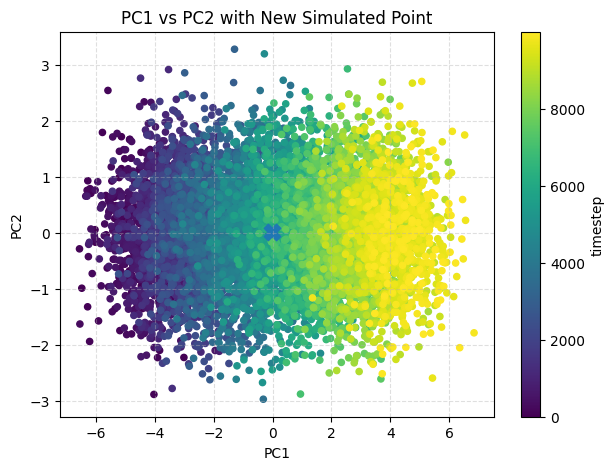

In [ ]:
new_pc1, new_pc2 = float(new_pca[0, 0]), float(new_pca[0, 1])

plt.figure(figsize=(7,5))
sc = plt.scatter(pc1, pc2, c=timestep, s=20)
plt.scatter([new_pc1], [new_pc2], marker='X', s=140)  # highlight new point
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 with New Simulated Point")
cbar = plt.colorbar(sc)
cbar.set_label("timestep")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()
